In [2]:
import matplotlib
%matplotlib inline
from pylab import *
import caesar
import h5py, os, sys
import yt, pickle, glob
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic as bst
from scipy.stats import binned_statistic_2d as bst2
from scipy.signal import savgol_filter as sgf

matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['ytick.labelsize'] = 18

safecolor={
    'silver':"#c0c0c0",
    'gray':"#808080",
    'black':"#000000",
    'red':"#ff0000",
    'maroon':"#800000",
    'yellow':"#ffff00",
    'olive':"#707030",
    'lime':"#00ee00",
    'green':"#009000",
    'aqua':"#00eeee",
    'teal':"#00a0a0",
    'blue':"#0000ff",
    'nave':"#000080",
    'fuchsia':"#ff00ff",
    'purple':"#900090"
}

In [3]:
# load Yang's data
M147=np.loadtxt("/home2/weiguang/Project-300-Clusters/optical/Yang-b2-d14.7",skiprows=1)
M150=np.loadtxt("/home2/weiguang/Project-300-Clusters/optical/Yang-b2-d15.0",skiprows=1)
M147[:,0] = 10.**(M147[:,0])/0.7/0.7*0.6777
M150[:,0] = 10.**(M150[:,0])/0.7/0.7*0.6777

In [4]:
#load gadgetX and gadgetmuisc
#ID(1) hostHalo(2) Region ID(3) Mvir(4) M_star(5)
Mshr=np.load("../optical/Music_Satellite.npy")
Xshr=np.load("../optical/G3X_Satellite.npy")

In [6]:
#Get M* satellite for GIZMO from AHF
GIZMO=np.loadtxt("GIZMO-Mass_snap_128-center-cluster.txt")  
if os.path.isfile('./data/GZS_Satellite.npy'):
    GZshr=np.load('./data/GZS_Satellite.npy')
else:
    fpath = "/home2/weiguang/The300/data/catalogues/AHF/"

    #regionID[0] hID[1] Mvir[2] Xc[3] Yc[4] Zc[5] Rvir[6] fMhires[7] cNFW[8] M500[9] R500[10] fgas[11] f*[12] Mbcg30, 50, 0.1R200 [13-15]
    # rr = np.sqrt(np.sum((GIZMO[:,3:6]-np.array([500000,500000,500000]))**2,axis=1))
    # GIZMO=GIZMO[(GIZMO[:,2]>4.0e14)&(rr<1800)]
    print(GIZMO.shape)

    GZshr=[]
    ZHid=np.int64(GIZMO[:,1]+0.1)
    ZRid=np.int32(GIZMO[:,0]+0.1)
    sname="/snap_128"
    n=0
    for i in np.arange(324):
        exts='0000'+str(ZRid[i])
        cn = 'NewMDCLUSTER_'+exts[-4:]
        f = glob.glob(fpath +"GIZMO/"+ cn + "/GIZMO-NewMDCLUSTER_" +cn[-4:]+"*.z0.000.AHF_halos")[0]
        tmpd = np.loadtxt(f, usecols=(0,1,2,3,64)) #ID(1) hostHalo(2) numSubStruct(3) Mvir(4) M_star(65)

        tmpd=tmpd[tmpd[:,1] == ZHid[i]]
        if tmpd.shape[0]>0:
            tmpd[:,2] = i+1
            GZshr.extend(tmpd.tolist())
        else:
            print('error in region: ',i+1,ZHid[i])

    GZshr=np.asarray(GZshr)
    np.save("./data/GZS_Satellite",GZshr)

#HID[0] hostHalo(1) RID[2] Mvir(3) M_star(4)

In [5]:
# load Semi galaxies
Galc=np.load("../optical/Galc_Satellite.npy") #ID(1) hostHalo(2) Region ID(3) Mvir(4) M_star(5) mag  'g','i','r','u','z'
Sag =np.load("../optical/Sag_Satellite.npy")
Sage=np.load("../optical/Sage_Satellite.npy")

In [19]:
Galc.shape,Sag.shape,Sage.shape

((329227, 10), (67494, 10), (65023, 5))

In [7]:
# For Stellar mass function
smb=np.arange(9,13.5,0.1)
sbx=(smb[1:]+smb[:-1])/2.0
idHMC=np.where(Mshr[:,1]<=1.1)[0]; idHXC=np.where(Xshr[:,1]<=1.1)[0]

msmf=np.zeros((len(idHMC),sbx.size),dtype=float); xsmf=np.zeros((len(idHXC),sbx.size),dtype=float)

for i,idp in enumerate(idHMC):
    ids = (Mshr[:,1]== Mshr[idp,0]) & (Mshr[:,4]>=1.0e9) & (Mshr[:,2]==Mshr[idp,2])
    msmf[i,:],x=np.histogram(np.log10(Mshr[ids,4]),bins=smb)

for i,idp in enumerate(idHXC):
    ids = (Xshr[:,1]== Xshr[idp,0]) & (Xshr[:,4]>=1.0e9) & (Xshr[:,2]==Xshr[idp,2])
    xsmf[i,:],x=np.histogram(np.log10(Xshr[ids,4]),bins=smb)
    
zsmf=np.zeros((GIZMO.shape[0],sbx.size),dtype=float)
for i,idp in enumerate(np.int64(GIZMO[:,1]+0.1)):
    ids = (np.int64(GZshr[:,1])== idp) & (GZshr[:,4]>=1.0e9) & (GZshr[:,2]==GIZMO[i,0])
    zsmf[i,:],x=np.histogram(np.log10(GZshr[ids,4]),bins=smb)

In [7]:
# For Stellar mass function -- Semi
idHGC=np.where(Galc[:,1]<=1.1)[0]; idHAC=np.where(Sag[:,1]<=1.1)[0]; idHEC=np.where(Sage[:,1]<=1.1)[0]; 
gsmf=np.zeros((len(idHGC),sbx.size),dtype=float); asmf=np.zeros((len(idHAC),sbx.size),dtype=float)
esmf=np.zeros((len(idHEC),sbx.size),dtype=float);

for i,idp in enumerate(idHGC):
    ids = Galc[:,1]== Galc[idp,0]
    gsmf[i,:],x=np.histogram(np.log10(Galc[ids,4]),bins=smb)

for i,idp in enumerate(idHAC):
    ids = Sag[:,1]== Sag[idp,0]
    asmf[i,:],x=np.histogram(np.log10(Sag[ids,4]),bins=smb)

for i,idp in enumerate(idHEC):
    ids = Sage[:,1]== Sage[idp,0]
    esmf[i,:],x=np.histogram(np.log10(Sage[ids,4]),bins=smb)

In [8]:
Msmf_m=np.median(msmf*10,axis=0); Msmf_e=np.std(msmf*10,axis=0)
Xsmf_m=np.median(xsmf*10,axis=0); Xsmf_e=np.std(xsmf*10,axis=0)
Zsmf_m=np.median(zsmf*10,axis=0); Zsmf_e=np.std(zsmf*10,axis=0)

In [9]:
Gsmf_m=np.median(gsmf*10,axis=0); Gsmf_e=np.std(gsmf*10,axis=0)
Asmf_m=np.median(asmf*10,axis=0); Asmf_e=np.std(asmf*10,axis=0)
Esmf_m=np.median(esmf*10,axis=0); Esmf_e=np.std(esmf*10,axis=0)

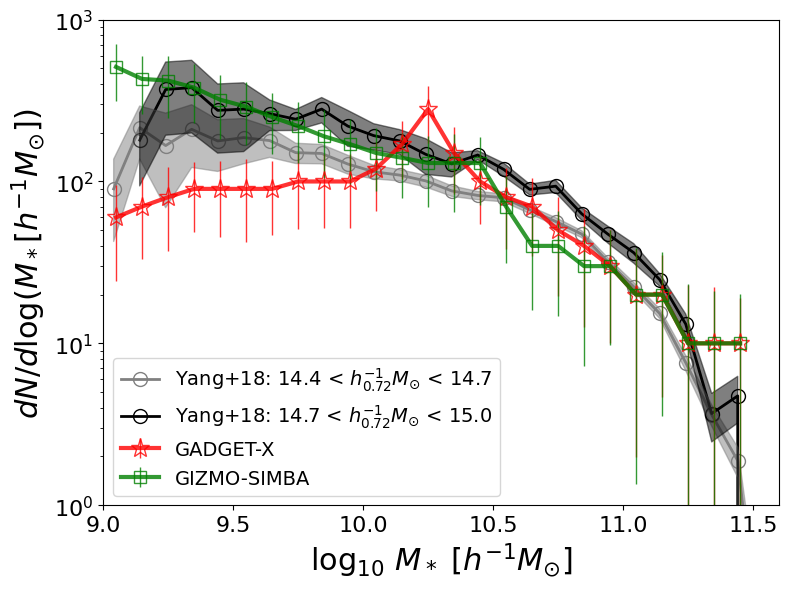

In [10]:
# Plot Satellite stellar mass function
fig=figure(figsize=(8,6))
plot(np.log10(M147[4:,0]),M147[4:,1],c='0.5', marker='o',mec='0.5',ms=10,
         mfc='none',lw=2,label="Yang+18: 14.4 < $h^{-1}_{0.72} M_{\odot}$ < 14.7",zorder=-5)
fill_between(np.log10(M147[4:,0]),M147[4:,1]+M147[4:,3],M147[4:,1]-M147[4:,3],color='0.5',alpha=0.5)
# errorbar(np.log10(M147[4:,0]),M147[4:,1],yerr=M147[4:,3],c='0.5', marker='o',mec='0.5',ms=10,
#          mfc='none',lw=2,label="Yang+18: 14.4 < $h^{-1}_{0.72} M_{\odot}$ < 14.7",zorder=-5)
# M147[4:,0]=np.log10(M147[4:,0]); M147[4:,2]=M147[4:,3]

plot(np.log10(M150[5:,0]),M150[5:,1],c='k', marker='o',mec='k',ms=10,mfc='none',
         lw=2,label="Yang+18: 14.7 < $h^{-1}_{0.72} M_{\odot}$ < 15.0",zorder=-5)
fill_between(np.log10(M150[5:,0]),M150[5:,1]+M150[5:,3],M150[5:,1]-M150[5:,3], color='k',alpha=0.5)
# errorbar(np.log10(M150[5:,0]),M150[5:,1],yerr=M150[5:,3],c='k', marker='o',mec='k',ms=10,mfc='none',
#          lw=2,label="Yang+18: 14.7 < $h^{-1}_{0.72} M_{\odot}$ < 15.0",zorder=-5)
# M150[5:,0]=np.log10(M150[5:,0]); M150[5:,2]=M150[5:,3]


# ids=Msmf_m>0
# # errorbar(sbx[ids]+0.02,Msmf_m[ids],yerr=Msmf_e[ids], c='r', marker='o',label="GadgetMUSIC",elinewidth=1)
# plot(sbx[ids],Msmf_m[ids], 'ro-', label="GADGET-MUSIC",zorder=9)
# # np.savetxt('The300-MUSIC.txt',np.asarray([sbx[ids],Msmf_m[ids]]).T,header='\log M_* [M_sun/h]    dN/dlogM*')

ids=Xsmf_m>0
errorbar(sbx[ids],Xsmf_m[ids],yerr=Xsmf_e[ids], c='r', marker='*',label="GADGET-X",elinewidth=1,lw=3,markersize=14,markerfacecolor='none',alpha=0.8)
# plot(sbx[ids],Xsmf_m[ids], 'b*-', label="GADGET-X",zorder=11)
# ids=CXsmf_m>0
# plot(sbx[ids],CXsmf_m[ids],'b^:', label="GADGET-X-Ceasar",zorder=11)
# np.savetxt('The300-X.txt',np.asarray([sbx[ids],Xsmf_m[ids]]).T,header='\log M_* [M_sun/h]    dN/dlogM*')

ids=Zsmf_m>0
errorbar(sbx[ids],Zsmf_m[ids],yerr=Zsmf_e[ids], c='g', marker='s',label="GIZMO-SIMBA",elinewidth=1,lw=3,markersize=8,alpha=0.8,markerfacecolor='none',)
# plot(sbx[ids],Zsmf_m[ids], 'gs-', label="GIZMO-SIMBA",zorder=9)
# np.savetxt('The300-X.txt',np.asarray([sbx[ids],Xsmf_m[ids]]).T,header='\log M_* [M_sun/h]    dN/dlogM*')

# ids=CZsmf_m>0
# plot(sbx[ids],CZsmf_m[ids], 'gp:', label="GIZMO-SIMBA-Ceasar",zorder=9)


#semi galaxies
# ids=Gsmf_m>0
# # errorbar(sbx[ids],Gsmf_m[ids],yerr=Gsmf_e[ids], c='k', marker='^',linestyle='--',label="Galacticus",elinewidth=1)
# plot(sbx[ids],Gsmf_m[ids],'k--',label="GALACTICUS",zorder=9)
# # np.savetxt('The300-GALACTICUS.txt',np.asarray([sbx[ids],Gsmf_m[ids]]).T,header='\log M_* [M_sun/h]    dN/dlogM*')

# ids=Asmf_m>0
# # errorbar(sbx[ids]+0.04,Asmf_m[ids],yerr=Asmf_e[ids], c='c', marker='<',linestyle=':',label="SAG",elinewidth=1)
# plot(sbx[ids],Asmf_m[ids],'c:',label="SAG",zorder=9)
# # np.savetxt('The300-SAG.txt',np.asarray([sbx[ids],Asmf_m[ids]]).T,header='\log M_* [M_sun/h]    dN/dlogM*')

# ids=Esmf_m>0
# # errorbar(sbx[ids]-0.04,Esmf_m[ids],yerr=Esmf_e[ids], c='g', marker='x',linestyle='-.',label="SAGE",elinewidth=1)
# plot(sbx[ids],Esmf_m[ids],'m-.',label="SAGE",zorder=9)


legend(ncol=1,fontsize=14)
yscale('log')
ylim(1,1000)
xlim(9.0,11.6)
xticks(fontsize=16)
yticks(fontsize=16)
ylabel("$dN / d\log(M_* [h^{-1} M_{\odot}])$",fontsize=22)
xlabel("$\log_{10}\ M_* \ [h^{-1} M_{\odot}]$",fontsize=22)
tight_layout()
savefig("plots/Ssmf-GS.pdf",dpi=300)

# New tests for Caesar galaxies

In [3]:
# GIZMO Get M* satellite from Caesar 
GMatch=np.loadtxt('GIZMO-Matched-AHFhalo-Caesar-galaxy.txt')

GZCshr=np.zeros((320*1000,2),dtype=np.f-loat32)

N=0
path='/home2/weiguang/data6/CL300_Caesar/'
for i in np.arange(1,325):
    ds=caesar.load(path+'NewMDCLUSTER_%04d/Caesar_snap_128.hdf5'%i)
    gpos=np.array([j.minpotpos for j in ds.galaxies])  #CoM
    gmas=np.array([j.masses['stellar'] for j in ds.galaxies])  #CoM
    dist=np.linalg.norm(gpos*0.6777-GIZMO[i-1,4:7],axis=1)

    ids=np.where(dist<=GIZMO[i-1,7])[0]
    n1=len(ids)
    ids=ids[ids != np.int32(GMatch[i-1,3]+0.1)]
    n2=len(ids)
    print(n1,n2)
    GZCshr[N:N+n2,0] = i
    GZCshr[N:N+n2,1] = gmas[ids]
    N+=n2

GZCshr=GZCshr[:N]
# np.save("./data/GZS_Satellite",GZshr)

#HID[0] hostHalo(1) RID[2] Mvir(3) M_star(4)

yt : [INFO     ] 2021-04-13 23:08:17,853 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0001/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:18,046 Found 2653 halos
yt : [INFO     ] 2021-04-13 23:08:18,055 Found 1786 galaxies


447 446


yt : [INFO     ] 2021-04-13 23:08:18,143 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0002/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:18,286 Found 2311 halos
yt : [INFO     ] 2021-04-13 23:08:18,295 Found 1557 galaxies


404 403


yt : [INFO     ] 2021-04-13 23:08:18,511 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0003/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:18,658 Found 2881 halos
yt : [INFO     ] 2021-04-13 23:08:18,668 Found 2346 galaxies


327 326


yt : [INFO     ] 2021-04-13 23:08:18,783 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0004/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:18,927 Found 2796 halos
yt : [INFO     ] 2021-04-13 23:08:18,936 Found 1992 galaxies


305 304


yt : [INFO     ] 2021-04-13 23:08:19,033 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0005/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:19,176 Found 2305 halos
yt : [INFO     ] 2021-04-13 23:08:19,186 Found 1475 galaxies


334 333


yt : [INFO     ] 2021-04-13 23:08:19,404 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0006/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:19,552 Found 2307 halos
yt : [INFO     ] 2021-04-13 23:08:19,562 Found 1502 galaxies


364 363


yt : [INFO     ] 2021-04-13 23:08:19,646 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0007/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:19,788 Found 2415 halos
yt : [INFO     ] 2021-04-13 23:08:19,796 Found 1684 galaxies


290 289


yt : [INFO     ] 2021-04-13 23:08:19,879 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0008/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:20,026 Found 2487 halos
yt : [INFO     ] 2021-04-13 23:08:20,035 Found 1694 galaxies


250 249


yt : [INFO     ] 2021-04-13 23:08:20,278 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0009/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:20,430 Found 2545 halos
yt : [INFO     ] 2021-04-13 23:08:20,439 Found 1685 galaxies


311 310


yt : [INFO     ] 2021-04-13 23:08:20,532 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0010/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:20,702 Found 2638 halos
yt : [INFO     ] 2021-04-13 23:08:20,712 Found 1863 galaxies


266 265


yt : [INFO     ] 2021-04-13 23:08:20,803 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0011/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:20,947 Found 2107 halos
yt : [INFO     ] 2021-04-13 23:08:20,957 Found 1353 galaxies


230 229


yt : [INFO     ] 2021-04-13 23:08:21,026 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0012/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:21,163 Found 2272 halos
yt : [INFO     ] 2021-04-13 23:08:21,171 Found 1478 galaxies


241 240


yt : [INFO     ] 2021-04-13 23:08:21,434 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0013/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:21,579 Found 2513 halos
yt : [INFO     ] 2021-04-13 23:08:21,590 Found 1760 galaxies


241 240


yt : [INFO     ] 2021-04-13 23:08:21,686 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0014/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:21,828 Found 2124 halos
yt : [INFO     ] 2021-04-13 23:08:21,837 Found 1350 galaxies


253 252


yt : [INFO     ] 2021-04-13 23:08:21,909 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0015/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:22,045 Found 1915 halos
yt : [INFO     ] 2021-04-13 23:08:22,054 Found 1139 galaxies


272 271


yt : [INFO     ] 2021-04-13 23:08:22,117 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0016/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:22,257 Found 3109 halos
yt : [INFO     ] 2021-04-13 23:08:22,266 Found 2452 galaxies


278 277


yt : [INFO     ] 2021-04-13 23:08:22,383 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0017/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:22,835 Found 2015 halos
yt : [INFO     ] 2021-04-13 23:08:22,844 Found 1316 galaxies


227 226


yt : [INFO     ] 2021-04-13 23:08:22,947 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0018/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:23,095 Found 2955 halos
yt : [INFO     ] 2021-04-13 23:08:23,105 Found 2258 galaxies


237 236


yt : [INFO     ] 2021-04-13 23:08:23,219 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0019/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:23,357 Found 2055 halos
yt : [INFO     ] 2021-04-13 23:08:23,366 Found 1393 galaxies


243 242


yt : [INFO     ] 2021-04-13 23:08:23,437 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0020/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:23,577 Found 2699 halos
yt : [INFO     ] 2021-04-13 23:08:23,585 Found 2173 galaxies


225 224


yt : [INFO     ] 2021-04-13 23:08:23,689 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0021/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:23,827 Found 2475 halos
yt : [INFO     ] 2021-04-13 23:08:23,835 Found 1550 galaxies


216 215


yt : [INFO     ] 2021-04-13 23:08:23,913 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0022/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:24,049 Found 2274 halos
yt : [INFO     ] 2021-04-13 23:08:24,058 Found 1426 galaxies


156 155


yt : [INFO     ] 2021-04-13 23:08:24,578 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0023/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:24,716 Found 2587 halos
yt : [INFO     ] 2021-04-13 23:08:24,725 Found 1754 galaxies


247 246


yt : [INFO     ] 2021-04-13 23:08:24,820 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0024/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:24,962 Found 2475 halos
yt : [INFO     ] 2021-04-13 23:08:24,998 Found 1654 galaxies


247 246


yt : [INFO     ] 2021-04-13 23:08:25,081 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0025/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:25,217 Found 2272 halos
yt : [INFO     ] 2021-04-13 23:08:25,226 Found 1401 galaxies


185 184


yt : [INFO     ] 2021-04-13 23:08:25,298 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0026/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:25,436 Found 2487 halos
yt : [INFO     ] 2021-04-13 23:08:25,445 Found 1821 galaxies


228 227


yt : [INFO     ] 2021-04-13 23:08:25,535 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0027/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:25,671 Found 2349 halos
yt : [INFO     ] 2021-04-13 23:08:25,679 Found 1501 galaxies


265 264


yt : [INFO     ] 2021-04-13 23:08:25,757 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0028/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:25,892 Found 2003 halos
yt : [INFO     ] 2021-04-13 23:08:25,900 Found 1258 galaxies


208 207


yt : [INFO     ] 2021-04-13 23:08:25,967 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0029/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:26,107 Found 2261 halos
yt : [INFO     ] 2021-04-13 23:08:26,115 Found 1408 galaxies


225 224


yt : [INFO     ] 2021-04-13 23:08:26,188 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0030/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:26,329 Found 2438 halos
yt : [INFO     ] 2021-04-13 23:08:26,338 Found 1557 galaxies


238 237


yt : [INFO     ] 2021-04-13 23:08:26,806 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0031/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:26,945 Found 2211 halos
yt : [INFO     ] 2021-04-13 23:08:26,954 Found 1378 galaxies


201 200


yt : [INFO     ] 2021-04-13 23:08:27,028 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0032/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:27,166 Found 1867 halos
yt : [INFO     ] 2021-04-13 23:08:27,174 Found 1068 galaxies


237 236


yt : [INFO     ] 2021-04-13 23:08:27,234 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0033/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:27,369 Found 2078 halos
yt : [INFO     ] 2021-04-13 23:08:27,378 Found 1222 galaxies


220 219


yt : [INFO     ] 2021-04-13 23:08:27,442 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0034/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:27,584 Found 1921 halos
yt : [INFO     ] 2021-04-13 23:08:27,593 Found 1080 galaxies


227 226


yt : [INFO     ] 2021-04-13 23:08:27,655 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0035/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:27,791 Found 2051 halos
yt : [INFO     ] 2021-04-13 23:08:27,799 Found 1313 galaxies


209 208


yt : [INFO     ] 2021-04-13 23:08:27,869 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0036/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:28,007 Found 1965 halos
yt : [INFO     ] 2021-04-13 23:08:28,016 Found 1211 galaxies


225 224


yt : [INFO     ] 2021-04-13 23:08:28,080 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0037/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:28,218 Found 2328 halos
yt : [INFO     ] 2021-04-13 23:08:28,226 Found 1505 galaxies


196 195


yt : [INFO     ] 2021-04-13 23:08:28,315 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0038/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:28,456 Found 1780 halos
yt : [INFO     ] 2021-04-13 23:08:28,469 Found 1078 galaxies


104 103


yt : [INFO     ] 2021-04-13 23:08:28,525 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0039/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:28,668 Found 2438 halos
yt : [INFO     ] 2021-04-13 23:08:28,676 Found 1863 galaxies


217 216


yt : [INFO     ] 2021-04-13 23:08:28,779 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0040/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:28,931 Found 2587 halos
yt : [INFO     ] 2021-04-13 23:08:28,946 Found 1674 galaxies


176 175


yt : [INFO     ] 2021-04-13 23:08:29,036 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0041/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:29,183 Found 2130 halos
yt : [INFO     ] 2021-04-13 23:08:29,194 Found 1211 galaxies


223 222


yt : [INFO     ] 2021-04-13 23:08:29,265 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0042/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:29,403 Found 2122 halos
yt : [INFO     ] 2021-04-13 23:08:29,412 Found 1321 galaxies


220 219


yt : [INFO     ] 2021-04-13 23:08:30,070 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0043/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:30,206 Found 2195 halos
yt : [INFO     ] 2021-04-13 23:08:30,214 Found 1459 galaxies


231 230


yt : [INFO     ] 2021-04-13 23:08:30,294 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0044/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:30,442 Found 2045 halos
yt : [INFO     ] 2021-04-13 23:08:30,451 Found 1292 galaxies


229 228


yt : [INFO     ] 2021-04-13 23:08:30,526 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0045/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:30,665 Found 2090 halos
yt : [INFO     ] 2021-04-13 23:08:30,674 Found 1396 galaxies


199 198


yt : [INFO     ] 2021-04-13 23:08:30,748 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0046/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:30,899 Found 2520 halos
yt : [INFO     ] 2021-04-13 23:08:30,907 Found 1507 galaxies


202 201


yt : [INFO     ] 2021-04-13 23:08:30,988 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0047/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:31,133 Found 2280 halos
yt : [INFO     ] 2021-04-13 23:08:31,142 Found 1596 galaxies


73 72


yt : [INFO     ] 2021-04-13 23:08:31,230 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0048/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:31,370 Found 1779 halos
yt : [INFO     ] 2021-04-13 23:08:31,383 Found 952 galaxies


188 187


yt : [INFO     ] 2021-04-13 23:08:31,447 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0049/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:31,593 Found 1942 halos
yt : [INFO     ] 2021-04-13 23:08:31,601 Found 1143 galaxies


179 178


yt : [INFO     ] 2021-04-13 23:08:31,668 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0050/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:31,810 Found 1820 halos
yt : [INFO     ] 2021-04-13 23:08:31,820 Found 1164 galaxies


185 184


yt : [INFO     ] 2021-04-13 23:08:31,890 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0051/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:32,035 Found 2156 halos
yt : [INFO     ] 2021-04-13 23:08:32,044 Found 1352 galaxies


179 178


yt : [INFO     ] 2021-04-13 23:08:32,115 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0052/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:32,257 Found 2220 halos
yt : [INFO     ] 2021-04-13 23:08:32,267 Found 1395 galaxies


217 216


yt : [INFO     ] 2021-04-13 23:08:32,344 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0053/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:32,489 Found 1673 halos
yt : [INFO     ] 2021-04-13 23:08:32,499 Found 1002 galaxies


157 156


yt : [INFO     ] 2021-04-13 23:08:32,560 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0054/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:32,702 Found 1896 halos
yt : [INFO     ] 2021-04-13 23:08:32,710 Found 1230 galaxies


219 218


yt : [INFO     ] 2021-04-13 23:08:32,782 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0055/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:32,926 Found 2253 halos
yt : [INFO     ] 2021-04-13 23:08:32,936 Found 1375 galaxies


211 210


yt : [INFO     ] 2021-04-13 23:08:33,011 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0056/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:33,160 Found 2018 halos
yt : [INFO     ] 2021-04-13 23:08:33,170 Found 1397 galaxies


226 225


yt : [INFO     ] 2021-04-13 23:08:33,925 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0057/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:34,063 Found 1930 halos
yt : [INFO     ] 2021-04-13 23:08:34,074 Found 1076 galaxies


207 206


yt : [INFO     ] 2021-04-13 23:08:34,137 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0058/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:34,280 Found 2101 halos
yt : [INFO     ] 2021-04-13 23:08:34,289 Found 1316 galaxies


179 178


yt : [INFO     ] 2021-04-13 23:08:34,366 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0059/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:34,502 Found 1761 halos
yt : [INFO     ] 2021-04-13 23:08:34,511 Found 1013 galaxies


184 183


yt : [INFO     ] 2021-04-13 23:08:34,569 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0060/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:34,708 Found 2182 halos
yt : [INFO     ] 2021-04-13 23:08:34,716 Found 1367 galaxies


209 208


yt : [INFO     ] 2021-04-13 23:08:34,791 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0061/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:34,935 Found 1894 halos
yt : [INFO     ] 2021-04-13 23:08:34,944 Found 1170 galaxies


213 212


yt : [INFO     ] 2021-04-13 23:08:35,018 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0062/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:35,160 Found 1913 halos
yt : [INFO     ] 2021-04-13 23:08:35,170 Found 956 galaxies


198 197


yt : [INFO     ] 2021-04-13 23:08:35,224 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0063/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:35,366 Found 1941 halos
yt : [INFO     ] 2021-04-13 23:08:35,374 Found 1281 galaxies


186 185


yt : [INFO     ] 2021-04-13 23:08:35,448 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0064/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:35,596 Found 2250 halos
yt : [INFO     ] 2021-04-13 23:08:35,607 Found 1515 galaxies


194 193


yt : [INFO     ] 2021-04-13 23:08:35,692 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0065/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:35,839 Found 2019 halos
yt : [INFO     ] 2021-04-13 23:08:35,848 Found 1199 galaxies


169 168


yt : [INFO     ] 2021-04-13 23:08:35,917 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0066/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:36,079 Found 2403 halos
yt : [INFO     ] 2021-04-13 23:08:36,089 Found 1435 galaxies


166 165


yt : [INFO     ] 2021-04-13 23:08:36,178 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0067/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:36,325 Found 1909 halos
yt : [INFO     ] 2021-04-13 23:08:36,334 Found 1225 galaxies


209 208


yt : [INFO     ] 2021-04-13 23:08:36,401 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0068/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:36,542 Found 2635 halos
yt : [INFO     ] 2021-04-13 23:08:36,550 Found 2028 galaxies


153 152


yt : [INFO     ] 2021-04-13 23:08:36,651 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0069/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:36,795 Found 1832 halos
yt : [INFO     ] 2021-04-13 23:08:36,803 Found 1148 galaxies


175 174


yt : [INFO     ] 2021-04-13 23:08:36,873 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0070/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:37,028 Found 2151 halos
yt : [INFO     ] 2021-04-13 23:08:37,037 Found 1299 galaxies


193 192


yt : [INFO     ] 2021-04-13 23:08:37,112 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0071/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:37,252 Found 1893 halos
yt : [INFO     ] 2021-04-13 23:08:37,260 Found 1116 galaxies


200 199


yt : [INFO     ] 2021-04-13 23:08:37,321 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0072/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:37,465 Found 2316 halos
yt : [INFO     ] 2021-04-13 23:08:37,473 Found 1544 galaxies


201 200


yt : [INFO     ] 2021-04-13 23:08:37,563 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0073/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:37,710 Found 2090 halos
yt : [INFO     ] 2021-04-13 23:08:37,719 Found 1322 galaxies


229 228


yt : [INFO     ] 2021-04-13 23:08:37,790 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0074/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:37,930 Found 2627 halos
yt : [INFO     ] 2021-04-13 23:08:37,938 Found 1846 galaxies


194 193


yt : [INFO     ] 2021-04-13 23:08:38,919 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0075/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:39,070 Found 1981 halos
yt : [INFO     ] 2021-04-13 23:08:39,079 Found 1131 galaxies


157 156


yt : [INFO     ] 2021-04-13 23:08:39,141 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0076/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:39,283 Found 2199 halos
yt : [INFO     ] 2021-04-13 23:08:39,291 Found 1274 galaxies


162 161


yt : [INFO     ] 2021-04-13 23:08:39,377 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0077/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:39,516 Found 1848 halos
yt : [INFO     ] 2021-04-13 23:08:39,525 Found 1181 galaxies


157 156


yt : [INFO     ] 2021-04-13 23:08:39,623 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0078/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:39,784 Found 2284 halos
yt : [INFO     ] 2021-04-13 23:08:39,793 Found 1579 galaxies


151 150


yt : [INFO     ] 2021-04-13 23:08:39,874 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0079/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:40,013 Found 2682 halos
yt : [INFO     ] 2021-04-13 23:08:40,022 Found 1770 galaxies


167 166


yt : [INFO     ] 2021-04-13 23:08:40,135 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0080/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:40,278 Found 3376 halos
yt : [INFO     ] 2021-04-13 23:08:40,287 Found 2520 galaxies


141 140


yt : [INFO     ] 2021-04-13 23:08:40,469 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0081/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:40,611 Found 1889 halos
yt : [INFO     ] 2021-04-13 23:08:40,619 Found 1071 galaxies


195 194


yt : [INFO     ] 2021-04-13 23:08:40,706 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0082/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:40,845 Found 2361 halos
yt : [INFO     ] 2021-04-13 23:08:40,853 Found 1627 galaxies


186 185


yt : [INFO     ] 2021-04-13 23:08:40,944 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0083/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:41,089 Found 2114 halos
yt : [INFO     ] 2021-04-13 23:08:41,097 Found 1199 galaxies


179 178


yt : [INFO     ] 2021-04-13 23:08:41,185 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0084/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:41,334 Found 1875 halos
yt : [INFO     ] 2021-04-13 23:08:41,344 Found 1026 galaxies


183 182


yt : [INFO     ] 2021-04-13 23:08:41,430 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0085/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:41,574 Found 2266 halos
yt : [INFO     ] 2021-04-13 23:08:41,584 Found 1420 galaxies


155 154


yt : [INFO     ] 2021-04-13 23:08:41,667 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0086/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:41,820 Found 1833 halos
yt : [INFO     ] 2021-04-13 23:08:41,828 Found 1045 galaxies


136 135


yt : [INFO     ] 2021-04-13 23:08:41,886 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0087/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:42,026 Found 1615 halos
yt : [INFO     ] 2021-04-13 23:08:42,035 Found 955 galaxies


182 181


yt : [INFO     ] 2021-04-13 23:08:42,095 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0088/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:42,239 Found 2314 halos
yt : [INFO     ] 2021-04-13 23:08:42,248 Found 1389 galaxies


195 194


yt : [INFO     ] 2021-04-13 23:08:42,356 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0089/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:42,502 Found 1929 halos
yt : [INFO     ] 2021-04-13 23:08:42,510 Found 1093 galaxies


166 165


yt : [INFO     ] 2021-04-13 23:08:42,593 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0090/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:42,733 Found 3201 halos
yt : [INFO     ] 2021-04-13 23:08:42,742 Found 2437 galaxies


137 136


yt : [INFO     ] 2021-04-13 23:08:42,886 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0091/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:43,035 Found 2109 halos
yt : [INFO     ] 2021-04-13 23:08:43,045 Found 1281 galaxies


163 162


yt : [INFO     ] 2021-04-13 23:08:43,140 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0092/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:43,278 Found 1942 halos
yt : [INFO     ] 2021-04-13 23:08:43,286 Found 1232 galaxies


121 120


yt : [INFO     ] 2021-04-13 23:08:43,352 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0093/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:43,498 Found 2084 halos
yt : [INFO     ] 2021-04-13 23:08:43,507 Found 1219 galaxies


145 144


yt : [INFO     ] 2021-04-13 23:08:43,607 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0094/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:43,755 Found 1864 halos
yt : [INFO     ] 2021-04-13 23:08:43,763 Found 1045 galaxies


170 169


yt : [INFO     ] 2021-04-13 23:08:43,825 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0095/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:43,975 Found 2203 halos
yt : [INFO     ] 2021-04-13 23:08:43,984 Found 1360 galaxies


169 168


yt : [INFO     ] 2021-04-13 23:08:44,057 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0096/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:44,212 Found 1858 halos
yt : [INFO     ] 2021-04-13 23:08:45,181 Found 1103 galaxies


130 129


yt : [INFO     ] 2021-04-13 23:08:45,248 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0097/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:45,391 Found 2481 halos
yt : [INFO     ] 2021-04-13 23:08:45,401 Found 1568 galaxies


179 178


yt : [INFO     ] 2021-04-13 23:08:45,509 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0098/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:45,657 Found 1951 halos
yt : [INFO     ] 2021-04-13 23:08:45,667 Found 1199 galaxies


159 158


yt : [INFO     ] 2021-04-13 23:08:45,757 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0099/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:45,894 Found 1915 halos
yt : [INFO     ] 2021-04-13 23:08:45,902 Found 1081 galaxies


127 126


yt : [INFO     ] 2021-04-13 23:08:45,982 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0100/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:46,125 Found 1850 halos
yt : [INFO     ] 2021-04-13 23:08:46,134 Found 1103 galaxies


195 194


yt : [INFO     ] 2021-04-13 23:08:46,201 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0101/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:46,354 Found 2846 halos
yt : [INFO     ] 2021-04-13 23:08:46,367 Found 2003 galaxies


167 166


yt : [INFO     ] 2021-04-13 23:08:46,508 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0102/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:46,683 Found 1972 halos
yt : [INFO     ] 2021-04-13 23:08:46,694 Found 1070 galaxies


149 148


yt : [INFO     ] 2021-04-13 23:08:46,778 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0103/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:46,929 Found 2060 halos
yt : [INFO     ] 2021-04-13 23:08:46,937 Found 1316 galaxies


157 156


yt : [INFO     ] 2021-04-13 23:08:47,010 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0104/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:47,152 Found 2378 halos
yt : [INFO     ] 2021-04-13 23:08:47,160 Found 1407 galaxies


134 133


yt : [INFO     ] 2021-04-13 23:08:47,262 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0105/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:47,411 Found 2337 halos
yt : [INFO     ] 2021-04-13 23:08:47,420 Found 1475 galaxies


117 116


yt : [INFO     ] 2021-04-13 23:08:47,520 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0106/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:47,671 Found 2266 halos
yt : [INFO     ] 2021-04-13 23:08:47,681 Found 1508 galaxies


164 163


yt : [INFO     ] 2021-04-13 23:08:47,759 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0107/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:47,894 Found 1521 halos
yt : [INFO     ] 2021-04-13 23:08:47,903 Found 883 galaxies


162 161


yt : [INFO     ] 2021-04-13 23:08:47,993 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0108/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:48,130 Found 1859 halos
yt : [INFO     ] 2021-04-13 23:08:48,140 Found 1134 galaxies


182 181


yt : [INFO     ] 2021-04-13 23:08:48,227 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0109/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:48,368 Found 1924 halos
yt : [INFO     ] 2021-04-13 23:08:48,376 Found 1228 galaxies


177 176


yt : [INFO     ] 2021-04-13 23:08:48,443 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0110/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:48,585 Found 2698 halos
yt : [INFO     ] 2021-04-13 23:08:48,594 Found 2110 galaxies


160 159


yt : [INFO     ] 2021-04-13 23:08:48,705 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0111/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:48,844 Found 2716 halos
yt : [INFO     ] 2021-04-13 23:08:48,855 Found 1980 galaxies


138 137


yt : [INFO     ] 2021-04-13 23:08:48,963 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0112/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:49,115 Found 1705 halos
yt : [INFO     ] 2021-04-13 23:08:49,125 Found 983 galaxies


179 178


yt : [INFO     ] 2021-04-13 23:08:49,215 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0113/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:49,365 Found 1838 halos
yt : [INFO     ] 2021-04-13 23:08:49,375 Found 1021 galaxies


133 132


yt : [INFO     ] 2021-04-13 23:08:49,460 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0114/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:49,603 Found 2049 halos
yt : [INFO     ] 2021-04-13 23:08:49,612 Found 1187 galaxies


144 143


yt : [INFO     ] 2021-04-13 23:08:49,680 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0115/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:49,822 Found 2200 halos
yt : [INFO     ] 2021-04-13 23:08:49,832 Found 1394 galaxies


103 102


yt : [INFO     ] 2021-04-13 23:08:49,911 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0116/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:50,057 Found 1924 halos
yt : [INFO     ] 2021-04-13 23:08:50,067 Found 1016 galaxies


185 184


yt : [INFO     ] 2021-04-13 23:08:50,162 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0117/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:50,301 Found 2215 halos
yt : [INFO     ] 2021-04-13 23:08:50,309 Found 1611 galaxies


152 151


yt : [INFO     ] 2021-04-13 23:08:50,393 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0118/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:50,533 Found 1713 halos
yt : [INFO     ] 2021-04-13 23:08:50,541 Found 1022 galaxies


154 153


yt : [INFO     ] 2021-04-13 23:08:50,601 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0119/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:50,743 Found 1867 halos
yt : [INFO     ] 2021-04-13 23:08:50,753 Found 1120 galaxies


146 145


yt : [INFO     ] 2021-04-13 23:08:50,837 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0120/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:50,979 Found 2441 halos
yt : [INFO     ] 2021-04-13 23:08:50,987 Found 1529 galaxies


138 137


yt : [INFO     ] 2021-04-13 23:08:51,098 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0121/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:51,243 Found 1813 halos
yt : [INFO     ] 2021-04-13 23:08:51,253 Found 1009 galaxies


130 129


yt : [INFO     ] 2021-04-13 23:08:51,344 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0122/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:51,495 Found 1672 halos
yt : [INFO     ] 2021-04-13 23:08:51,505 Found 921 galaxies


158 157


yt : [INFO     ] 2021-04-13 23:08:51,584 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0123/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:51,728 Found 1705 halos
yt : [INFO     ] 2021-04-13 23:08:51,738 Found 939 galaxies


159 158


yt : [INFO     ] 2021-04-13 23:08:51,832 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0124/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:51,975 Found 1801 halos
yt : [INFO     ] 2021-04-13 23:08:51,983 Found 1018 galaxies


169 168


yt : [INFO     ] 2021-04-13 23:08:53,398 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0125/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:53,543 Found 1647 halos
yt : [INFO     ] 2021-04-13 23:08:53,552 Found 893 galaxies


166 165


yt : [INFO     ] 2021-04-13 23:08:53,631 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0126/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:53,784 Found 1905 halos
yt : [INFO     ] 2021-04-13 23:08:53,792 Found 1050 galaxies


151 150


yt : [INFO     ] 2021-04-13 23:08:53,852 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0127/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:53,995 Found 1897 halos
yt : [INFO     ] 2021-04-13 23:08:54,004 Found 1103 galaxies


154 153


yt : [INFO     ] 2021-04-13 23:08:54,068 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0128/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:54,212 Found 1958 halos
yt : [INFO     ] 2021-04-13 23:08:54,221 Found 1238 galaxies


132 131


yt : [INFO     ] 2021-04-13 23:08:54,318 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0129/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:54,462 Found 2242 halos
yt : [INFO     ] 2021-04-13 23:08:54,471 Found 1460 galaxies


107 106


yt : [INFO     ] 2021-04-13 23:08:54,576 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0130/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:54,718 Found 2367 halos
yt : [INFO     ] 2021-04-13 23:08:54,728 Found 1647 galaxies


131 130


yt : [INFO     ] 2021-04-13 23:08:54,811 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0131/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:54,955 Found 1705 halos
yt : [INFO     ] 2021-04-13 23:08:54,964 Found 1031 galaxies


131 130


yt : [INFO     ] 2021-04-13 23:08:55,023 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0132/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:55,176 Found 2163 halos
yt : [INFO     ] 2021-04-13 23:08:55,185 Found 1288 galaxies


145 144


yt : [INFO     ] 2021-04-13 23:08:55,277 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0133/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:55,419 Found 1856 halos
yt : [INFO     ] 2021-04-13 23:08:55,427 Found 966 galaxies


148 147


yt : [INFO     ] 2021-04-13 23:08:55,511 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0134/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:55,655 Found 2097 halos
yt : [INFO     ] 2021-04-13 23:08:55,664 Found 1149 galaxies


113 112


yt : [INFO     ] 2021-04-13 23:08:55,754 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0135/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:55,906 Found 1541 halos
yt : [INFO     ] 2021-04-13 23:08:55,916 Found 796 galaxies


147 146


yt : [INFO     ] 2021-04-13 23:08:55,969 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0136/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:56,122 Found 2206 halos
yt : [INFO     ] 2021-04-13 23:08:56,131 Found 1362 galaxies


155 154


yt : [INFO     ] 2021-04-13 23:08:56,229 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0137/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:56,385 Found 2118 halos
yt : [INFO     ] 2021-04-13 23:08:56,395 Found 1196 galaxies


142 141


yt : [INFO     ] 2021-04-13 23:08:56,488 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0138/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:56,633 Found 2023 halos
yt : [INFO     ] 2021-04-13 23:08:56,641 Found 1126 galaxies


139 138


yt : [INFO     ] 2021-04-13 23:08:56,730 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0139/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:56,872 Found 1776 halos
yt : [INFO     ] 2021-04-13 23:08:56,880 Found 1011 galaxies


154 153


yt : [INFO     ] 2021-04-13 23:08:56,971 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0140/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:57,115 Found 1694 halos
yt : [INFO     ] 2021-04-13 23:08:57,124 Found 861 galaxies


144 143


yt : [INFO     ] 2021-04-13 23:08:57,199 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0141/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:57,337 Found 1803 halos
yt : [INFO     ] 2021-04-13 23:08:57,346 Found 933 galaxies


141 140


yt : [INFO     ] 2021-04-13 23:08:57,409 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0142/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:57,546 Found 2698 halos
yt : [INFO     ] 2021-04-13 23:08:57,555 Found 1863 galaxies


150 149


yt : [INFO     ] 2021-04-13 23:08:57,665 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0143/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:57,805 Found 1588 halos
yt : [INFO     ] 2021-04-13 23:08:57,813 Found 893 galaxies


144 143


yt : [INFO     ] 2021-04-13 23:08:57,888 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0144/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:58,028 Found 1997 halos
yt : [INFO     ] 2021-04-13 23:08:58,036 Found 1210 galaxies


125 124


yt : [INFO     ] 2021-04-13 23:08:58,131 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0145/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:58,284 Found 2215 halos
yt : [INFO     ] 2021-04-13 23:08:58,293 Found 1358 galaxies


138 137


yt : [INFO     ] 2021-04-13 23:08:58,392 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0146/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:58,545 Found 1769 halos
yt : [INFO     ] 2021-04-13 23:08:58,555 Found 984 galaxies


118 117


yt : [INFO     ] 2021-04-13 23:08:58,663 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0147/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:58,839 Found 2026 halos
yt : [INFO     ] 2021-04-13 23:08:58,849 Found 1225 galaxies


147 146


yt : [INFO     ] 2021-04-13 23:08:58,946 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0148/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:59,089 Found 1669 halos
yt : [INFO     ] 2021-04-13 23:08:59,099 Found 886 galaxies


103 102


yt : [INFO     ] 2021-04-13 23:08:59,184 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0149/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:59,326 Found 2268 halos
yt : [INFO     ] 2021-04-13 23:08:59,336 Found 1468 galaxies


141 140


yt : [INFO     ] 2021-04-13 23:08:59,441 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0150/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:59,584 Found 1929 halos
yt : [INFO     ] 2021-04-13 23:08:59,593 Found 1072 galaxies


145 144


yt : [INFO     ] 2021-04-13 23:08:59,656 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0151/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:08:59,807 Found 1949 halos
yt : [INFO     ] 2021-04-13 23:08:59,817 Found 1193 galaxies


123 122


yt : [INFO     ] 2021-04-13 23:08:59,887 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0152/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:00,023 Found 2234 halos
yt : [INFO     ] 2021-04-13 23:09:00,032 Found 1398 galaxies


159 158


yt : [INFO     ] 2021-04-13 23:09:00,105 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0153/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:00,245 Found 2595 halos
yt : [INFO     ] 2021-04-13 23:09:00,254 Found 1647 galaxies


126 125


yt : [INFO     ] 2021-04-13 23:09:00,340 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0154/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:00,492 Found 2025 halos
yt : [INFO     ] 2021-04-13 23:09:00,501 Found 1063 galaxies


137 136


yt : [INFO     ] 2021-04-13 23:09:00,562 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0155/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:00,696 Found 1760 halos
yt : [INFO     ] 2021-04-13 23:09:00,706 Found 944 galaxies


121 120


yt : [INFO     ] 2021-04-13 23:09:00,760 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0156/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:00,902 Found 1875 halos
yt : [INFO     ] 2021-04-13 23:09:00,911 Found 1110 galaxies


163 162


yt : [INFO     ] 2021-04-13 23:09:00,972 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0157/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:01,116 Found 2073 halos
yt : [INFO     ] 2021-04-13 23:09:01,126 Found 1242 galaxies


138 137


yt : [INFO     ] 2021-04-13 23:09:01,200 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0158/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:01,344 Found 2154 halos
yt : [INFO     ] 2021-04-13 23:09:01,353 Found 1289 galaxies


144 143


yt : [INFO     ] 2021-04-13 23:09:01,429 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0159/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:01,574 Found 2287 halos
yt : [INFO     ] 2021-04-13 23:09:01,586 Found 1322 galaxies


153 152


yt : [INFO     ] 2021-04-13 23:09:01,684 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0160/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:01,829 Found 2104 halos
yt : [INFO     ] 2021-04-13 23:09:01,840 Found 1287 galaxies


147 146


yt : [INFO     ] 2021-04-13 23:09:01,945 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0161/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:02,083 Found 1911 halos
yt : [INFO     ] 2021-04-13 23:09:02,091 Found 1142 galaxies


132 131


yt : [INFO     ] 2021-04-13 23:09:02,154 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0162/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:02,292 Found 2510 halos
yt : [INFO     ] 2021-04-13 23:09:02,301 Found 1630 galaxies


122 121


yt : [INFO     ] 2021-04-13 23:09:02,382 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0163/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:02,516 Found 2459 halos
yt : [INFO     ] 2021-04-13 23:09:02,525 Found 1692 galaxies


131 130


yt : [INFO     ] 2021-04-13 23:09:04,612 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0164/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:04,756 Found 1895 halos
yt : [INFO     ] 2021-04-13 23:09:04,764 Found 1003 galaxies


142 141


yt : [INFO     ] 2021-04-13 23:09:04,822 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0165/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:04,967 Found 1890 halos
yt : [INFO     ] 2021-04-13 23:09:04,977 Found 1003 galaxies


143 142


yt : [INFO     ] 2021-04-13 23:09:05,040 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0166/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:05,176 Found 1581 halos
yt : [INFO     ] 2021-04-13 23:09:05,184 Found 796 galaxies


121 120


yt : [INFO     ] 2021-04-13 23:09:05,252 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0167/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:05,395 Found 2117 halos
yt : [INFO     ] 2021-04-13 23:09:05,404 Found 1304 galaxies


153 152


yt : [INFO     ] 2021-04-13 23:09:05,476 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0168/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:05,633 Found 2352 halos
yt : [INFO     ] 2021-04-13 23:09:05,643 Found 1605 galaxies


126 125


yt : [INFO     ] 2021-04-13 23:09:05,730 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0169/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:05,868 Found 1803 halos
yt : [INFO     ] 2021-04-13 23:09:05,877 Found 1173 galaxies


115 114


yt : [INFO     ] 2021-04-13 23:09:05,962 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0170/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:06,104 Found 1994 halos
yt : [INFO     ] 2021-04-13 23:09:06,113 Found 1270 galaxies


151 150


yt : [INFO     ] 2021-04-13 23:09:06,205 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0171/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:06,349 Found 2066 halos
yt : [INFO     ] 2021-04-13 23:09:06,358 Found 1274 galaxies


94 93


yt : [INFO     ] 2021-04-13 23:09:06,452 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0172/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:06,603 Found 2181 halos
yt : [INFO     ] 2021-04-13 23:09:06,617 Found 1271 galaxies


135 134


yt : [INFO     ] 2021-04-13 23:09:06,716 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0173/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:06,884 Found 1820 halos
yt : [INFO     ] 2021-04-13 23:09:06,893 Found 944 galaxies


144 143


yt : [INFO     ] 2021-04-13 23:09:06,949 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0174/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:07,094 Found 2831 halos
yt : [INFO     ] 2021-04-13 23:09:07,102 Found 2113 galaxies


100 99


yt : [INFO     ] 2021-04-13 23:09:07,283 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0175/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:07,433 Found 2572 halos
yt : [INFO     ] 2021-04-13 23:09:07,442 Found 1711 galaxies


115 114


yt : [INFO     ] 2021-04-13 23:09:07,527 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0176/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:07,662 Found 1694 halos
yt : [INFO     ] 2021-04-13 23:09:07,671 Found 878 galaxies


125 124


yt : [INFO     ] 2021-04-13 23:09:07,751 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0177/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:07,895 Found 2014 halos
yt : [INFO     ] 2021-04-13 23:09:07,903 Found 1257 galaxies


148 147


yt : [INFO     ] 2021-04-13 23:09:07,999 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0178/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:08,138 Found 1869 halos
yt : [INFO     ] 2021-04-13 23:09:08,147 Found 1065 galaxies


126 125


yt : [INFO     ] 2021-04-13 23:09:08,228 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0179/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:08,364 Found 1603 halos
yt : [INFO     ] 2021-04-13 23:09:08,373 Found 817 galaxies


164 163


yt : [INFO     ] 2021-04-13 23:09:08,421 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0180/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:08,559 Found 2054 halos
yt : [INFO     ] 2021-04-13 23:09:08,569 Found 1148 galaxies


127 126


yt : [INFO     ] 2021-04-13 23:09:08,638 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0181/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:08,781 Found 1333 halos
yt : [INFO     ] 2021-04-13 23:09:08,790 Found 655 galaxies


121 120


yt : [INFO     ] 2021-04-13 23:09:08,834 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0182/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:08,976 Found 2055 halos
yt : [INFO     ] 2021-04-13 23:09:08,987 Found 1171 galaxies


127 126


yt : [INFO     ] 2021-04-13 23:09:09,065 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0183/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:09,209 Found 1786 halos
yt : [INFO     ] 2021-04-13 23:09:09,218 Found 1002 galaxies


145 144


yt : [INFO     ] 2021-04-13 23:09:09,286 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0184/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:09,435 Found 1738 halos
yt : [INFO     ] 2021-04-13 23:09:09,445 Found 1027 galaxies


155 154


yt : [INFO     ] 2021-04-13 23:09:09,514 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0185/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:09,657 Found 2099 halos
yt : [INFO     ] 2021-04-13 23:09:09,666 Found 1349 galaxies


121 120


yt : [INFO     ] 2021-04-13 23:09:09,737 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0186/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:09,884 Found 1677 halos
yt : [INFO     ] 2021-04-13 23:09:09,894 Found 971 galaxies


137 136


yt : [INFO     ] 2021-04-13 23:09:09,972 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0187/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:10,116 Found 1789 halos
yt : [INFO     ] 2021-04-13 23:09:10,125 Found 956 galaxies


133 132


yt : [INFO     ] 2021-04-13 23:09:10,182 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0188/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:10,322 Found 2039 halos
yt : [INFO     ] 2021-04-13 23:09:10,330 Found 1360 galaxies


147 146


yt : [INFO     ] 2021-04-13 23:09:10,409 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0189/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:10,550 Found 1984 halos
yt : [INFO     ] 2021-04-13 23:09:10,558 Found 1132 galaxies


120 119


yt : [INFO     ] 2021-04-13 23:09:10,621 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0190/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:10,757 Found 1911 halos
yt : [INFO     ] 2021-04-13 23:09:10,766 Found 1139 galaxies


135 134


yt : [INFO     ] 2021-04-13 23:09:10,835 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0191/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:10,978 Found 2075 halos
yt : [INFO     ] 2021-04-13 23:09:10,986 Found 1112 galaxies


132 131


yt : [INFO     ] 2021-04-13 23:09:11,053 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0192/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:11,200 Found 2051 halos
yt : [INFO     ] 2021-04-13 23:09:11,209 Found 1245 galaxies


128 127


yt : [INFO     ] 2021-04-13 23:09:11,277 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0193/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:11,415 Found 2132 halos
yt : [INFO     ] 2021-04-13 23:09:11,424 Found 1270 galaxies


153 152


yt : [INFO     ] 2021-04-13 23:09:11,493 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0194/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:11,639 Found 1643 halos
yt : [INFO     ] 2021-04-13 23:09:11,649 Found 1054 galaxies


115 114


yt : [INFO     ] 2021-04-13 23:09:11,711 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0195/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:11,863 Found 2313 halos
yt : [INFO     ] 2021-04-13 23:09:11,873 Found 1333 galaxies


131 130


yt : [INFO     ] 2021-04-13 23:09:11,959 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0196/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:12,102 Found 1797 halos
yt : [INFO     ] 2021-04-13 23:09:12,111 Found 1130 galaxies


136 135


yt : [INFO     ] 2021-04-13 23:09:12,185 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0197/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:12,333 Found 2083 halos
yt : [INFO     ] 2021-04-13 23:09:12,343 Found 1423 galaxies


136 135


yt : [INFO     ] 2021-04-13 23:09:12,425 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0198/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:12,564 Found 2006 halos
yt : [INFO     ] 2021-04-13 23:09:12,575 Found 1175 galaxies


153 152


yt : [INFO     ] 2021-04-13 23:09:12,643 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0199/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:12,783 Found 1825 halos
yt : [INFO     ] 2021-04-13 23:09:12,792 Found 1036 galaxies


83 82


yt : [INFO     ] 2021-04-13 23:09:12,854 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0200/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:12,999 Found 1814 halos
yt : [INFO     ] 2021-04-13 23:09:13,010 Found 1119 galaxies


128 127


yt : [INFO     ] 2021-04-13 23:09:13,080 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0201/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:13,219 Found 1826 halos
yt : [INFO     ] 2021-04-13 23:09:13,227 Found 1054 galaxies


124 123


yt : [INFO     ] 2021-04-13 23:09:13,287 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0202/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:13,422 Found 2207 halos
yt : [INFO     ] 2021-04-13 23:09:13,430 Found 1307 galaxies


121 120


yt : [INFO     ] 2021-04-13 23:09:13,501 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0203/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:13,650 Found 1809 halos
yt : [INFO     ] 2021-04-13 23:09:13,659 Found 960 galaxies


157 156


yt : [INFO     ] 2021-04-13 23:09:13,717 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0204/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:13,898 Found 2048 halos
yt : [INFO     ] 2021-04-13 23:09:13,908 Found 1191 galaxies


112 111


yt : [INFO     ] 2021-04-13 23:09:13,974 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0205/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:14,114 Found 2082 halos
yt : [INFO     ] 2021-04-13 23:09:14,122 Found 1288 galaxies


129 128


yt : [INFO     ] 2021-04-13 23:09:14,190 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0206/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:14,332 Found 2175 halos
yt : [INFO     ] 2021-04-13 23:09:14,342 Found 1395 galaxies


116 115


yt : [INFO     ] 2021-04-13 23:09:14,423 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0207/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:14,570 Found 1896 halos
yt : [INFO     ] 2021-04-13 23:09:14,580 Found 1045 galaxies


134 133


yt : [INFO     ] 2021-04-13 23:09:14,649 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0208/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:14,796 Found 2261 halos
yt : [INFO     ] 2021-04-13 23:09:14,805 Found 1371 galaxies


100 99


yt : [INFO     ] 2021-04-13 23:09:14,893 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0209/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:15,039 Found 1721 halos
yt : [INFO     ] 2021-04-13 23:09:15,048 Found 937 galaxies


107 106


yt : [INFO     ] 2021-04-13 23:09:15,107 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0210/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:15,253 Found 1527 halos
yt : [INFO     ] 2021-04-13 23:09:15,262 Found 777 galaxies


127 126


yt : [INFO     ] 2021-04-13 23:09:15,310 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0211/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:15,453 Found 2079 halos
yt : [INFO     ] 2021-04-13 23:09:15,462 Found 1207 galaxies


138 137


yt : [INFO     ] 2021-04-13 23:09:17,764 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0212/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:17,902 Found 1786 halos
yt : [INFO     ] 2021-04-13 23:09:17,910 Found 945 galaxies


144 143


yt : [INFO     ] 2021-04-13 23:09:17,968 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0213/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:18,108 Found 2727 halos
yt : [INFO     ] 2021-04-13 23:09:18,118 Found 1815 galaxies


107 106


yt : [INFO     ] 2021-04-13 23:09:18,224 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0214/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:18,361 Found 2120 halos
yt : [INFO     ] 2021-04-13 23:09:18,369 Found 1369 galaxies


132 131


yt : [INFO     ] 2021-04-13 23:09:18,442 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0215/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:18,585 Found 1825 halos
yt : [INFO     ] 2021-04-13 23:09:18,594 Found 1007 galaxies


131 130


yt : [INFO     ] 2021-04-13 23:09:18,653 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0216/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:18,789 Found 1910 halos
yt : [INFO     ] 2021-04-13 23:09:18,799 Found 1057 galaxies


114 113


yt : [INFO     ] 2021-04-13 23:09:18,864 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0217/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:19,008 Found 2022 halos
yt : [INFO     ] 2021-04-13 23:09:19,017 Found 1264 galaxies


127 126


yt : [INFO     ] 2021-04-13 23:09:19,087 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0218/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:19,224 Found 1799 halos
yt : [INFO     ] 2021-04-13 23:09:19,232 Found 976 galaxies


122 121


yt : [INFO     ] 2021-04-13 23:09:19,291 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0219/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:19,438 Found 2058 halos
yt : [INFO     ] 2021-04-13 23:09:19,447 Found 1266 galaxies


132 131


yt : [INFO     ] 2021-04-13 23:09:19,520 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0220/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:19,682 Found 1678 halos
yt : [INFO     ] 2021-04-13 23:09:19,692 Found 983 galaxies


124 123


yt : [INFO     ] 2021-04-13 23:09:19,770 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0221/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:19,951 Found 2080 halos
yt : [INFO     ] 2021-04-13 23:09:19,962 Found 1268 galaxies


136 135


yt : [INFO     ] 2021-04-13 23:09:20,034 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0222/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:20,178 Found 1917 halos
yt : [INFO     ] 2021-04-13 23:09:20,188 Found 1146 galaxies


140 139


yt : [INFO     ] 2021-04-13 23:09:20,253 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0223/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:20,392 Found 2171 halos
yt : [INFO     ] 2021-04-13 23:09:20,401 Found 1383 galaxies


112 111


yt : [INFO     ] 2021-04-13 23:09:20,478 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0224/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:20,635 Found 1996 halos
yt : [INFO     ] 2021-04-13 23:09:20,645 Found 1167 galaxies


141 140


yt : [INFO     ] 2021-04-13 23:09:20,718 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0225/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:20,858 Found 1536 halos
yt : [INFO     ] 2021-04-13 23:09:20,867 Found 898 galaxies


101 100


yt : [INFO     ] 2021-04-13 23:09:20,930 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0226/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:21,069 Found 2227 halos
yt : [INFO     ] 2021-04-13 23:09:21,077 Found 1386 galaxies


119 118


yt : [INFO     ] 2021-04-13 23:09:21,157 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0227/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:21,311 Found 1796 halos
yt : [INFO     ] 2021-04-13 23:09:21,320 Found 1028 galaxies


149 148


yt : [INFO     ] 2021-04-13 23:09:21,379 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0228/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:21,518 Found 1643 halos
yt : [INFO     ] 2021-04-13 23:09:21,527 Found 970 galaxies


121 120


yt : [INFO     ] 2021-04-13 23:09:21,584 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0229/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:21,746 Found 1473 halos
yt : [INFO     ] 2021-04-13 23:09:21,755 Found 808 galaxies


123 122


yt : [INFO     ] 2021-04-13 23:09:21,818 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0230/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:21,988 Found 1531 halos
yt : [INFO     ] 2021-04-13 23:09:21,999 Found 892 galaxies


143 142


yt : [INFO     ] 2021-04-13 23:09:22,060 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0231/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:22,238 Found 2585 halos
yt : [INFO     ] 2021-04-13 23:09:22,247 Found 1622 galaxies


112 111


yt : [INFO     ] 2021-04-13 23:09:22,364 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0232/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:22,523 Found 2323 halos
yt : [INFO     ] 2021-04-13 23:09:22,533 Found 1461 galaxies


107 106


yt : [INFO     ] 2021-04-13 23:09:22,620 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0233/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:22,766 Found 1918 halos
yt : [INFO     ] 2021-04-13 23:09:22,775 Found 1020 galaxies


124 123


yt : [INFO     ] 2021-04-13 23:09:22,837 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0234/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:22,975 Found 1874 halos
yt : [INFO     ] 2021-04-13 23:09:22,985 Found 1097 galaxies


128 127


yt : [INFO     ] 2021-04-13 23:09:23,054 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0235/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:23,192 Found 1553 halos
yt : [INFO     ] 2021-04-13 23:09:23,203 Found 841 galaxies


124 123


yt : [INFO     ] 2021-04-13 23:09:23,257 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0236/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:23,396 Found 1642 halos
yt : [INFO     ] 2021-04-13 23:09:23,404 Found 944 galaxies


154 153


yt : [INFO     ] 2021-04-13 23:09:23,465 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0237/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:23,608 Found 1777 halos
yt : [INFO     ] 2021-04-13 23:09:23,617 Found 894 galaxies


122 121


yt : [INFO     ] 2021-04-13 23:09:23,684 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0238/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:23,829 Found 2003 halos
yt : [INFO     ] 2021-04-13 23:09:23,838 Found 1102 galaxies


89 88


yt : [INFO     ] 2021-04-13 23:09:23,900 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0239/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:24,038 Found 2238 halos
yt : [INFO     ] 2021-04-13 23:09:24,045 Found 1322 galaxies


85 84


yt : [INFO     ] 2021-04-13 23:09:24,115 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0240/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:24,257 Found 1891 halos
yt : [INFO     ] 2021-04-13 23:09:24,265 Found 1044 galaxies


104 103


yt : [INFO     ] 2021-04-13 23:09:24,324 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0241/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:24,470 Found 1770 halos
yt : [INFO     ] 2021-04-13 23:09:24,479 Found 1074 galaxies


107 106


yt : [INFO     ] 2021-04-13 23:09:24,541 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0242/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:24,684 Found 1877 halos
yt : [INFO     ] 2021-04-13 23:09:24,693 Found 1150 galaxies


121 120


yt : [INFO     ] 2021-04-13 23:09:24,762 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0243/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:24,920 Found 2261 halos
yt : [INFO     ] 2021-04-13 23:09:24,934 Found 1440 galaxies


146 145


yt : [INFO     ] 2021-04-13 23:09:25,029 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0244/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:25,178 Found 1733 halos
yt : [INFO     ] 2021-04-13 23:09:25,187 Found 1028 galaxies


121 120


yt : [INFO     ] 2021-04-13 23:09:25,251 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0245/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:25,389 Found 2571 halos
yt : [INFO     ] 2021-04-13 23:09:25,397 Found 1659 galaxies


119 118


yt : [INFO     ] 2021-04-13 23:09:25,484 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0246/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:25,622 Found 1765 halos
yt : [INFO     ] 2021-04-13 23:09:25,631 Found 935 galaxies


125 124


yt : [INFO     ] 2021-04-13 23:09:25,685 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0247/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:25,829 Found 1403 halos
yt : [INFO     ] 2021-04-13 23:09:25,838 Found 781 galaxies


119 118


yt : [INFO     ] 2021-04-13 23:09:25,888 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0248/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:26,043 Found 1910 halos
yt : [INFO     ] 2021-04-13 23:09:26,052 Found 1329 galaxies


103 102


yt : [INFO     ] 2021-04-13 23:09:26,124 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0249/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:26,264 Found 1433 halos
yt : [INFO     ] 2021-04-13 23:09:26,274 Found 796 galaxies


123 122


yt : [INFO     ] 2021-04-13 23:09:26,322 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0250/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:26,464 Found 2042 halos
yt : [INFO     ] 2021-04-13 23:09:26,473 Found 1251 galaxies


121 120


yt : [INFO     ] 2021-04-13 23:09:26,547 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0251/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:26,702 Found 1690 halos
yt : [INFO     ] 2021-04-13 23:09:26,712 Found 997 galaxies


128 127


yt : [INFO     ] 2021-04-13 23:09:26,770 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0252/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:26,908 Found 1789 halos
yt : [INFO     ] 2021-04-13 23:09:26,916 Found 854 galaxies


115 114


yt : [INFO     ] 2021-04-13 23:09:26,972 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0253/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:27,107 Found 1664 halos
yt : [INFO     ] 2021-04-13 23:09:27,115 Found 986 galaxies


103 102


yt : [INFO     ] 2021-04-13 23:09:27,175 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0254/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:27,320 Found 1675 halos
yt : [INFO     ] 2021-04-13 23:09:27,330 Found 990 galaxies


127 126


yt : [INFO     ] 2021-04-13 23:09:27,402 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0255/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:27,551 Found 2244 halos
yt : [INFO     ] 2021-04-13 23:09:27,560 Found 1377 galaxies


89 88


yt : [INFO     ] 2021-04-13 23:09:27,644 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0256/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:27,793 Found 1563 halos
yt : [INFO     ] 2021-04-13 23:09:27,803 Found 807 galaxies


119 118


yt : [INFO     ] 2021-04-13 23:09:27,861 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0257/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:28,008 Found 2398 halos
yt : [INFO     ] 2021-04-13 23:09:28,019 Found 1601 galaxies


115 114


yt : [INFO     ] 2021-04-13 23:09:28,116 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0258/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:28,254 Found 1809 halos
yt : [INFO     ] 2021-04-13 23:09:28,262 Found 1062 galaxies


129 128


yt : [INFO     ] 2021-04-13 23:09:28,323 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0259/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:28,463 Found 1459 halos
yt : [INFO     ] 2021-04-13 23:09:28,471 Found 754 galaxies


99 98


yt : [INFO     ] 2021-04-13 23:09:28,519 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0260/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:28,665 Found 1721 halos
yt : [INFO     ] 2021-04-13 23:09:28,674 Found 1036 galaxies


130 129


yt : [INFO     ] 2021-04-13 23:09:28,736 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0261/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:28,885 Found 1619 halos
yt : [INFO     ] 2021-04-13 23:09:28,894 Found 899 galaxies


114 113


yt : [INFO     ] 2021-04-13 23:09:28,949 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0262/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:29,088 Found 1926 halos
yt : [INFO     ] 2021-04-13 23:09:29,096 Found 1075 galaxies


122 121


yt : [INFO     ] 2021-04-13 23:09:29,158 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0263/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:29,292 Found 2084 halos
yt : [INFO     ] 2021-04-13 23:09:29,300 Found 1202 galaxies


111 110


yt : [INFO     ] 2021-04-13 23:09:29,373 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0264/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:29,519 Found 2004 halos
yt : [INFO     ] 2021-04-13 23:09:29,528 Found 1283 galaxies


128 127


yt : [INFO     ] 2021-04-13 23:09:29,606 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0265/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:29,750 Found 1962 halos
yt : [INFO     ] 2021-04-13 23:09:29,758 Found 1183 galaxies


121 120


yt : [INFO     ] 2021-04-13 23:09:29,825 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0266/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:29,964 Found 1727 halos
yt : [INFO     ] 2021-04-13 23:09:29,973 Found 927 galaxies


103 102


yt : [INFO     ] 2021-04-13 23:09:30,027 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0267/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:30,167 Found 1977 halos
yt : [INFO     ] 2021-04-13 23:09:30,175 Found 1191 galaxies


114 113


yt : [INFO     ] 2021-04-13 23:09:30,242 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0268/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:30,379 Found 1964 halos
yt : [INFO     ] 2021-04-13 23:09:30,394 Found 1102 galaxies


97 96


yt : [INFO     ] 2021-04-13 23:09:30,469 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0269/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:30,615 Found 1426 halos
yt : [INFO     ] 2021-04-13 23:09:30,625 Found 657 galaxies


93 92


yt : [INFO     ] 2021-04-13 23:09:30,670 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0270/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:30,816 Found 1824 halos
yt : [INFO     ] 2021-04-13 23:09:30,827 Found 1183 galaxies


107 106


yt : [INFO     ] 2021-04-13 23:09:30,896 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0271/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:31,041 Found 1973 halos
yt : [INFO     ] 2021-04-13 23:09:31,051 Found 1100 galaxies


116 115


yt : [INFO     ] 2021-04-13 23:09:31,116 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0272/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:31,268 Found 2152 halos
yt : [INFO     ] 2021-04-13 23:09:31,279 Found 1175 galaxies


113 112


yt : [INFO     ] 2021-04-13 23:09:31,354 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0273/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:31,502 Found 2182 halos
yt : [INFO     ] 2021-04-13 23:09:31,511 Found 1341 galaxies


121 120


yt : [INFO     ] 2021-04-13 23:09:31,584 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0274/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:31,738 Found 1862 halos
yt : [INFO     ] 2021-04-13 23:09:31,747 Found 1008 galaxies


89 88


yt : [INFO     ] 2021-04-13 23:09:31,806 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0275/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:31,949 Found 1959 halos
yt : [INFO     ] 2021-04-13 23:09:31,959 Found 1107 galaxies


134 133


yt : [INFO     ] 2021-04-13 23:09:35,423 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0276/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:35,573 Found 2003 halos
yt : [INFO     ] 2021-04-13 23:09:35,582 Found 1280 galaxies


105 104


yt : [INFO     ] 2021-04-13 23:09:35,655 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0277/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:35,800 Found 2100 halos
yt : [INFO     ] 2021-04-13 23:09:35,809 Found 1160 galaxies


106 105


yt : [INFO     ] 2021-04-13 23:09:35,879 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0278/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:36,019 Found 2068 halos
yt : [INFO     ] 2021-04-13 23:09:36,027 Found 1207 galaxies


114 113


yt : [INFO     ] 2021-04-13 23:09:36,095 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0279/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:36,233 Found 1619 halos
yt : [INFO     ] 2021-04-13 23:09:36,242 Found 887 galaxies


122 121


yt : [INFO     ] 2021-04-13 23:09:36,302 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0280/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:36,459 Found 1763 halos
yt : [INFO     ] 2021-04-13 23:09:36,470 Found 1042 galaxies


137 136


yt : [INFO     ] 2021-04-13 23:09:36,540 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0281/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:36,691 Found 1919 halos
yt : [INFO     ] 2021-04-13 23:09:36,700 Found 1193 galaxies


104 103


yt : [INFO     ] 2021-04-13 23:09:36,770 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0282/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:36,911 Found 2133 halos
yt : [INFO     ] 2021-04-13 23:09:36,925 Found 1303 galaxies


111 110


yt : [INFO     ] 2021-04-13 23:09:37,000 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0283/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:37,141 Found 2095 halos
yt : [INFO     ] 2021-04-13 23:09:37,150 Found 1346 galaxies


103 102


yt : [INFO     ] 2021-04-13 23:09:37,224 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0284/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:37,374 Found 2087 halos
yt : [INFO     ] 2021-04-13 23:09:37,382 Found 1566 galaxies


94 93


yt : [INFO     ] 2021-04-13 23:09:37,464 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0285/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:37,606 Found 1734 halos
yt : [INFO     ] 2021-04-13 23:09:37,615 Found 1011 galaxies


108 107


yt : [INFO     ] 2021-04-13 23:09:37,675 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0286/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:37,818 Found 1716 halos
yt : [INFO     ] 2021-04-13 23:09:37,831 Found 1044 galaxies


124 123


yt : [INFO     ] 2021-04-13 23:09:37,900 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0287/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:38,040 Found 2122 halos
yt : [INFO     ] 2021-04-13 23:09:38,049 Found 1354 galaxies


128 127


yt : [INFO     ] 2021-04-13 23:09:38,121 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0288/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:38,256 Found 1496 halos
yt : [INFO     ] 2021-04-13 23:09:38,265 Found 781 galaxies


110 109


yt : [INFO     ] 2021-04-13 23:09:38,317 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0289/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:38,460 Found 1644 halos
yt : [INFO     ] 2021-04-13 23:09:38,469 Found 1066 galaxies


107 106


yt : [INFO     ] 2021-04-13 23:09:38,535 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0290/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:38,680 Found 1785 halos
yt : [INFO     ] 2021-04-13 23:09:38,689 Found 1060 galaxies


124 123


yt : [INFO     ] 2021-04-13 23:09:38,755 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0291/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:38,900 Found 2128 halos
yt : [INFO     ] 2021-04-13 23:09:38,909 Found 1222 galaxies


129 128


yt : [INFO     ] 2021-04-13 23:09:38,978 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0292/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:39,127 Found 2073 halos
yt : [INFO     ] 2021-04-13 23:09:39,136 Found 1220 galaxies


98 97


yt : [INFO     ] 2021-04-13 23:09:39,211 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0293/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:39,356 Found 1728 halos
yt : [INFO     ] 2021-04-13 23:09:39,364 Found 1047 galaxies


119 118


yt : [INFO     ] 2021-04-13 23:09:39,429 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0294/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:39,564 Found 1768 halos
yt : [INFO     ] 2021-04-13 23:09:39,573 Found 1004 galaxies


76 75


yt : [INFO     ] 2021-04-13 23:09:39,631 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0295/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:39,779 Found 1538 halos
yt : [INFO     ] 2021-04-13 23:09:39,789 Found 791 galaxies


100 99


yt : [INFO     ] 2021-04-13 23:09:39,843 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0296/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:39,992 Found 1522 halos
yt : [INFO     ] 2021-04-13 23:09:40,000 Found 761 galaxies


102 101


yt : [INFO     ] 2021-04-13 23:09:40,049 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0297/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:40,187 Found 1737 halos
yt : [INFO     ] 2021-04-13 23:09:40,195 Found 907 galaxies


113 112


yt : [INFO     ] 2021-04-13 23:09:40,249 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0298/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:40,392 Found 2413 halos
yt : [INFO     ] 2021-04-13 23:09:40,402 Found 1705 galaxies


117 116


yt : [INFO     ] 2021-04-13 23:09:40,494 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0299/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:40,651 Found 1624 halos
yt : [INFO     ] 2021-04-13 23:09:40,659 Found 868 galaxies


113 112


yt : [INFO     ] 2021-04-13 23:09:40,711 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0300/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:40,852 Found 2672 halos
yt : [INFO     ] 2021-04-13 23:09:40,860 Found 1812 galaxies


97 96


yt : [INFO     ] 2021-04-13 23:09:40,958 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0301/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:41,102 Found 1904 halos
yt : [INFO     ] 2021-04-13 23:09:41,116 Found 1078 galaxies


108 107


yt : [INFO     ] 2021-04-13 23:09:41,196 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0302/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:41,357 Found 1765 halos
yt : [INFO     ] 2021-04-13 23:09:41,369 Found 1047 galaxies


128 127


yt : [INFO     ] 2021-04-13 23:09:41,437 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0303/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:41,578 Found 1698 halos
yt : [INFO     ] 2021-04-13 23:09:41,587 Found 1039 galaxies


114 113


yt : [INFO     ] 2021-04-13 23:09:41,647 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0304/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:41,792 Found 1942 halos
yt : [INFO     ] 2021-04-13 23:09:41,800 Found 1212 galaxies


108 107


yt : [INFO     ] 2021-04-13 23:09:41,867 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0305/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:42,011 Found 1710 halos
yt : [INFO     ] 2021-04-13 23:09:42,020 Found 891 galaxies


100 99


yt : [INFO     ] 2021-04-13 23:09:42,075 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0306/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:42,225 Found 1497 halos
yt : [INFO     ] 2021-04-13 23:09:42,233 Found 885 galaxies


106 105


yt : [INFO     ] 2021-04-13 23:09:42,287 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0307/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:42,428 Found 2640 halos
yt : [INFO     ] 2021-04-13 23:09:42,437 Found 1731 galaxies


104 103


yt : [INFO     ] 2021-04-13 23:09:42,528 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0308/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:42,686 Found 2229 halos
yt : [INFO     ] 2021-04-13 23:09:42,695 Found 1257 galaxies


133 132


yt : [INFO     ] 2021-04-13 23:09:42,764 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0309/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:42,902 Found 2198 halos
yt : [INFO     ] 2021-04-13 23:09:42,911 Found 1475 galaxies


116 115


yt : [INFO     ] 2021-04-13 23:09:42,989 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0310/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:43,129 Found 1947 halos
yt : [INFO     ] 2021-04-13 23:09:43,138 Found 1238 galaxies


125 124


yt : [INFO     ] 2021-04-13 23:09:43,208 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0311/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:43,360 Found 1486 halos
yt : [INFO     ] 2021-04-13 23:09:43,371 Found 813 galaxies


120 119


yt : [INFO     ] 2021-04-13 23:09:43,428 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0312/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:43,606 Found 2197 halos
yt : [INFO     ] 2021-04-13 23:09:43,617 Found 1362 galaxies


96 95


yt : [INFO     ] 2021-04-13 23:09:43,716 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0313/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:43,857 Found 1858 halos
yt : [INFO     ] 2021-04-13 23:09:43,865 Found 1090 galaxies


100 99


yt : [INFO     ] 2021-04-13 23:09:43,931 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0314/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:44,074 Found 1640 halos
yt : [INFO     ] 2021-04-13 23:09:44,082 Found 945 galaxies


115 114


yt : [INFO     ] 2021-04-13 23:09:44,139 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0315/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:44,283 Found 2129 halos
yt : [INFO     ] 2021-04-13 23:09:44,292 Found 1258 galaxies


127 126


yt : [INFO     ] 2021-04-13 23:09:44,378 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0316/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:44,518 Found 1920 halos
yt : [INFO     ] 2021-04-13 23:09:44,526 Found 1156 galaxies


122 121


yt : [INFO     ] 2021-04-13 23:09:44,591 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0317/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:44,735 Found 1825 halos
yt : [INFO     ] 2021-04-13 23:09:44,744 Found 999 galaxies


110 109


yt : [INFO     ] 2021-04-13 23:09:44,804 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0318/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:44,949 Found 2016 halos
yt : [INFO     ] 2021-04-13 23:09:44,960 Found 1303 galaxies


99 98


yt : [INFO     ] 2021-04-13 23:09:45,038 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0319/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:45,175 Found 2368 halos
yt : [INFO     ] 2021-04-13 23:09:45,183 Found 1545 galaxies


73 72


yt : [INFO     ] 2021-04-13 23:09:45,266 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0320/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:45,407 Found 1537 halos
yt : [INFO     ] 2021-04-13 23:09:45,417 Found 757 galaxies


105 104


yt : [INFO     ] 2021-04-13 23:09:45,465 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0321/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:45,610 Found 1775 halos
yt : [INFO     ] 2021-04-13 23:09:45,619 Found 994 galaxies


115 114


yt : [INFO     ] 2021-04-13 23:09:45,684 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0322/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:45,861 Found 1711 halos
yt : [INFO     ] 2021-04-13 23:09:45,872 Found 809 galaxies


114 113


yt : [INFO     ] 2021-04-13 23:09:45,928 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0323/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:46,081 Found 2084 halos
yt : [INFO     ] 2021-04-13 23:09:46,090 Found 1224 galaxies


102 101


yt : [INFO     ] 2021-04-13 23:09:46,157 Opening /home2/weiguang/data6/CL300_Caesar/NewMDCLUSTER_0324/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-13 23:09:46,296 Found 1366 halos
yt : [INFO     ] 2021-04-13 23:09:46,305 Found 715 galaxies


110 109


In [40]:
czsmf=np.zeros((324,sbx.size),dtype=float)
for i in np.arange(1,325):
    ids = np.int32(GZCshr[:,0]+0.1)== i
    czsmf[i-1,:],x=np.histogram(np.log10(GZCshr[ids,1]*0.6777),bins=smb)
CZsmf_m=np.median(czsmf*10,axis=0); CZsmf_e=np.std(czsmf*10,axis=0)

In [53]:
# GadgetX
G3X=np.loadtxt("../Halo_mass_function_mass-difference/G3X_Mass_snap_128-center-cluster.txt")  
XMatch=np.loadtxt('G3X-Matched-AHFhalo-Caesar-galaxy.txt')

GXCshr=np.zeros((320*1000,2),dtype=np.float32)

N=0
path='/home2/weiguang/data6/G3X_Caesar/'
for i in np.arange(1,325):
    ds=caesar.load(path+'NewMDCLUSTER_%04d/Caesar_snap_128.hdf5'%i)
    gpos=np.array([j.pos for j in ds.galaxies])  #CoM
    gmas=np.array([j.masses['stellar'] for j in ds.galaxies])  #CoM
    dist=np.linalg.norm(gpos*0.6777-G3X[i-1,3:6],axis=1)

    ids=np.where(dist<=G3X[i-1,6])[0]
#     n1=len(ids)
    ids=ids[ids != np.int32(XMatch[i-1,3]+0.1)]
    n2=len(ids)
#     print(n1,n2)
    GXCshr[N:N+n2,0] = i
    GXCshr[N:N+n2,1] = gmas[ids]
    N+=n2

GXCshr=GXCshr[:N]

yt : [INFO     ] 2021-04-14 15:37:49,398 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0001/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-14 15:37:49,541 Found 2518 halos
yt : [INFO     ] 2021-04-14 15:37:49,549 Found 3038 galaxies
yt : [INFO     ] 2021-04-14 15:37:49,685 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0002/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-14 15:37:49,820 Found 2176 halos
yt : [INFO     ] 2021-04-14 15:37:49,827 Found 2546 galaxies
yt : [INFO     ] 2021-04-14 15:37:49,944 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0003/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-14 15:37:50,081 Found 2732 halos
yt : [INFO     ] 2021-04-14 15:37:50,089 Found 3945 galaxies
yt : [INFO     ] 2021-04-14 15:37:50,261 Opening /home2/weiguang/data6/G3X_Caesar/NewMDCLUSTER_0004/Caesar_snap_128.hdf5
yt : [INFO     ] 2021-04-14 15:37:50,397 Found 2642 halos
yt : [INFO     ] 2021-04-14 15:37:50,405 Found 3236 galaxies
yt : [INFO     ] 2021-04-14 15:37:50,549

In [54]:
cxsmf=np.zeros((324,sbx.size),dtype=float)
for i in np.arange(1,325):
    ids = np.int32(GXCshr[:,0]+0.1)== i
    cxsmf[i-1,:],x=np.histogram(np.log10(GXCshr[ids,1]*0.6777),bins=smb)
CXsmf_m=np.median(cxsmf*10,axis=0); CXsmf_e=np.std(cxsmf*10,axis=0)
CXsmf_m

array([160., 130., 120., 110., 100., 100., 100., 100., 100., 110., 130.,
       280., 205., 110.,  90.,  70.,  60.,  40.,  40.,  20.,  20.,  10.,
        10.,  10.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [56]:
ds.galaxies[0].info()

{'GroupID': 0,
 'L_FIR': 0.0 Lsun,
 'absmag': {'2mass_h': -26.272022247314453,
            '2mass_j': -26.098596572875977,
            '2mass_ks': -25.99538230895996,
            'b': -24.549060821533203,
            'bessell_l': -25.266189575195312,
            'bessell_lp': -25.125816345214844,
            'bessell_m': -24.610071182250977,
            'buser_b': -24.602340698242188,
            'cfht_b': -24.604028701782227,
            'cfht_i': -25.760425567626953,
            'cfht_r': -25.461347579956055,
            'cousins_i': -25.71904945373535,
            'cousins_r': -25.44261360168457,
            'des_g': -24.830106735229492,
            'des_i': -25.68155860900879,
            'des_r': -25.397281646728516,
            'des_y': -26.01127815246582,
            'des_z': -25.932058334350586,
            'fors_r': -25.437925338745117,
            'fors_v': -25.150724411010742,
            'galex_fuv': -22.598281860351562,
            'galex_nuv': -22.570148468017578,
       